<a href="https://colab.research.google.com/github/mbougha/Cours-RI/blob/main/CoursRI_DeepLearning_Text_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cours sur Deep learning pour du Texte. 
Une bonne partie des algorithmes ci dessous sont pris de (https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

Vous pourrez aussi accéder au GitHub du livre.
(https://github.com/fchollet/deep-learning-with-python-notebooks)

PS : Il existe plusieurs plateformes pour faire du Deep Learning : Tensorflow, Pytorch, Keras, Keras est maintenant intégré dans Tensorflow. Ls exemples ci-dessous se basent sur tensorflow et keras


## Quelques commandes pour le traitement d'un texte
Traiter un texte revient à mettre le texte en minusule, spliter le textes en mots (tockenization), compter chaque mot, construire un dictionnaire (le vocabulaire regroupant tous les mots), puis indexer les mots (donner un indice à chaque mot) pour faciliter sa manipulation. 

### Utilisation directe de la classe TextVectorization
Le mieux est d'utiliser directement la classe TextVectorization. On fournit une collection de textes (un dataset). , TextVectorization fait tout: tockensation, elination des stopwords, création des index  (un terme un indice).
Visualiser la classe : https://keras.io/api/layers/preprocessing_layers/text/text_vectorization/

In [24]:
from tensorflow.keras.layers import TextVectorization
## output mode indique le type de vecteur  que l'on soouhaite avoir
# unigrams/bigrams; count, tf_idf, muti_hot, ?)
## 
text_vectorization = TextVectorization(
    output_mode="count",
)

#on peut aussi choisir la taille du "ngrams=1" , "ngrams=2"
#text_vectorization = TextVectorization(
#    ngrams=2
#    output_mode="count",tf_idf; multi_hot; 
#)
#La classe 
#tf.keras.layers.TextVectorization(
#    max_tokens=None,
#    standardize="lower_and_strip_punctuation",
#    split="whitespace",
#    ngrams=None,
#    output_mode="int",
#    output_sequence_length=None,
#    pad_to_max_tokens=False,
#    vocabulary=None,
#    idf_weights=None,
#    sparse=False,
#    ragged=False,
#    **kwargs
#)



On peut aussi écrire (appeler) ses propres fonctions dans TextVectorization

In [ ]:
import re
import string
import tensorflow as tf

#Par exemple ici les attrbuts standardize et split prennent de nouvelles fonctions 
## 

def custom_standardization_fn(string_tensor):
    lowercase_string = tf.strings.lower(string_tensor)
    return tf.strings.regex_replace(
        lowercase_string, f"[{re.escape(string.punctuation)}]", "")

def custom_split_fn(string_tensor):
    return tf.strings.split(string_tensor)

text_vectorization = TextVectorization(
    output_mode="int",
    standardize=custom_standardization_fn,
    split=custom_split_fn,
)

In [25]:
## La dataset, composée de trois documents
dataset = [
    "I write, erase, rewrite",
    "Erase again, and then",
    "A poppy blooms.",
]

# il suffit d'appeler la méthode adapt (le travail sera fait)
text_vectorization.adapt(dataset)

Lister le vocabulaire

In [26]:
vocabulary=text_vectorization.get_vocabulary()
# le resultat st l'space vectoriel représentant l'ensemble des mots trouvés dans le dataset

In [27]:
#Afficher le vecteur d'une phrase
test_sentence = "I write, rewrite, and still rewrite again"

# on fournit la phrase à text_vectorization, il renvoie  le vecteur

encoded_sentence = text_vectorization(test_sentence)
print(encoded_sentence)

tf.Tensor([1. 0. 1. 0. 2. 0. 1. 0. 1. 1. 0.], shape=(11,), dtype=float32)


In [ ]:
inverse_vocab = dict(enumerate(vocabulary))
decoded_sentence = " ".join(inverse_vocab[int(i)] for i in encoded_sentence)
print(decoded_sentence)

erase [UNK] erase [UNK] write [UNK] erase [UNK] [UNK] erase erase [UNK]


##  Deep learning pour du Texte.
Nous prendrons le dataset IMDB (textes donnant des reviews avec sa polarité Positive/négative)

### Préparation d'un dataset
- On peut télécharger un dataset ou l'utiliser directement si il est sur votre répértoire

In [ ]:
!curl -O https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz
!tar -xf aclImdb_v1.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 80.2M  100 80.2M    0     0  28.5M      0  0:00:02  0:00:02 --:--:-- 28.5M


In [ ]:
# supprimer les fichiers 
!rm -r aclImdb/train/unsup

In [ ]:
##  Visualiser un bout de texte
!cat aclImdb/train/pos/4077_10.txt

- On peut  utiliser des données** qui sont sur son propre répértoire, par exemple ici les données sont sur Drive.

- copier le fichier sur Colab puis décompesser

In [10]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
## Pour copier les données sur colab
!cp  /content/drive/MyDrive/MyColabNotebooks/Mes_cours/data/aclImdb.tar.gz .
## décompesser
!tar -xzf aclImdb.tar.gz

In [29]:
!cat content/aclImdb/train/pos/4077_10.txt

I first saw this back in the early 90s on UK TV, i did like it then but i missed the chance to tape it, many years passed but the film always stuck with me and i lost hope of seeing it TV again, the main thing that stuck with me was the end, the hole castle part really touched me, its easy to watch, has a great story, great music, the list goes on and on, its OK me saying how good it is but everyone will take there own best bits away with them once they have seen it, yes the animation is top notch and beautiful to watch, it does show its age in a very few parts but that has now become part of it beauty, i am so glad it has came out on DVD as it is one of my top 10 films of all time. Buy it or rent it just see it, best viewing is at night alone with drink and food in reach so you don't have to stop the film.<br /><br />Enjoy

In [5]:
import os, pathlib
# les données sont sur mon drive. le mieux est de les copier sur Colab (voir ci-dessous)
#  sur drive
#dataset_dir='/content/drive/MyDrive/MyColabNotebooks/Mes_cours/data'

# sur colab /content' n'est pas obligatoire
dataset_dir='content/'

train_dir=os.path.join(dataset_dir, 'aclImdb/train')
test_dir=os.path.join(dataset_dir, 'aclImdb/test')
os.listdir(train_dir)
# rempalacer ls répartoires aclImdb/train val) et test par les vôtres

print("ATTENTION ICI SEULS LES REPERTOIRE TRAIN ET TEST EXISTENT. LE REPERTOIRE VAL n'eXISTE PAS.")



ATTENTION ICI SEULS LES REPERTOIRE TRAIN ET TEST EXISTENT. LE REPERTOIRE VAL n'eXISTE PAS.


### Charger les données

Le dataset aclImdb, comporte deux répertoires, train et test (chacun comporte un répértoire de revues positives et un  répertoire de revues  négatives. Pour la phase d'entrainement on a besoin de données de validation. 

Deux OPTIONS pour les construire.


#####Option 1 : On crée un répertoire val, et on 'move' une partie des données de train vers val. 



In [ ]:
# Option 1 Option 1  Option 1   Option 1   Option 1  Option 1  Option 1   Option 1   Option 1 

import os, pathlib, shutil, random
# Le répértoire aclIMDB comporte deux répértoirtes importants
# test et train, chacun de ces répértoires comporte un répértoire pos (liste des textes positifs) 
# et un repértoire neg, listant les textes (les reviews) négatifs.
# ce bout de programme permet d'extraire à partir du répértoire train un ensemble de textes qui sera utilisé 
# dans la phase de validation

base_dir = pathlib.Path("aclImdb")
val_dir = base_dir / "val"
train_dir = base_dir / "train"
for category in ("neg", "pos"):
    # création du represtoire val (validation) 20 du train. 
    # puis move de ces 20% de train vers val
    os.makedirs(val_dir / category)
    files = os.listdir(train_dir / category)
    random.Random(1337).shuffle(files)
    num_val_samples = int(0.2 * len(files))
    val_files = files[-num_val_samples:]
    for fname in val_files:
        shutil.move(train_dir / category / fname,
                    val_dir / category / fname)

Dans les deux options les données sont chargées grace à keras.utils.text_dataset_from_directory.
(visualiser la fonction https://keras.io/api/data_loading/text/)

3 tenseurs (train_ds, val_ds et test_ds) sont crées.

** Les textes sont rangés par paquets (batch_size) de 32. Le batch_size indique le paquet de données (training) à traiter par training.


In [ ]:
# la fonction keras.utils.text_dataset_from_directory lit les données et renvoie un tenseur.
# un tf.data.Dataset object

from tensorflow import keras
batch_size = 32

train_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/train", 
    #batch_size=batch_size
)
val_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/val", 
    #batch_size=batch_size
)
test_ds = keras.utils.text_dataset_from_directory(
    "aclImdb/test", 
    #batch_size=batch_size
)


#la fonction tf.keras.utils.text_dataset_from_directory(
#   directory,
#   labels="inferred",
#   label_mode="int",
#   class_names=None,
#    batch_size=32,
#    max_length=None,
#    shuffle=True,
#    seed=None,
#    validation_split=None,
#    subset=None,
#    follow_links=False,
#)


#####Option 2 : Lors de la lecture des données on donne le pourcentage de données que l'on prend pour la **validation**

In [30]:
#Option 2 Option 2 Option 2  Option 2  Option 2  Option 2  Option 2  Option 2  Option 2  

train_ds = keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=32,
    validation_split=0.25,
    subset="training",
    seed=1337,
)

val_ds = keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=32,
    validation_split=0.25,
    subset="validation",
    seed=1337,
)

test_ds = keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=32,
  
)

Found 25000 files belonging to 2 classes.
Using 18750 files for training.
Found 25000 files belonging to 2 classes.
Using 6250 files for validation.
Found 25000 files belonging to 2 classes.


** Affichage de la "forme" dimension et le contenu du premier Batch


In [7]:
for inputs, targets in train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
# le premier texte, inputs[0]    
    print("inputs[0]:", inputs[0])
# sa polarité targets[0]
    print("targets[0]:", targets[0])
    break

inputs.shape: (32,)
inputs.dtype: <dtype: 'string'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor(b'I\'ve seen tons of science fiction from the 70s; some horrendously bad, and others thought provoking and truly frightening. Soylent Green fits into the latter category. Yes, at times it\'s a little campy, and yes, the furniture is good for a giggle or two, but some of the film seems awfully prescient. Here we have a film, 9 years before Blade Runner, that dares to imagine the future as somthing dark, scary, and nihilistic. Both Charlton Heston and Edward G. Robinson fare far better in this than The Ten Commandments, and Robinson\'s assisted-suicide scene is creepily prescient of Kevorkian and his ilk. Some of the attitudes are dated (can you imagine a filmmaker getting away with the "women as furniture" concept in our oh-so-politically-correct-90s?), but it\'s rare to find a film from the Me Decade that actually can make you think. This is one I\'d love to see

### Premier exemple: **texte représenté par sac de mots**
Les données sont chargées dans dans trois tenseurs.
On passe aux étapes suivantes (Deep learning)

In [8]:
from tensorflow.keras.layers import TextVectorization

## definition d'une variable text_vectorisation (on prend une version binaire 1/0)
# on peut aussi prendre tf_idf, bigrams,etc. vir ci dessous 

text_vectorization = TextVectorization(
    max_tokens=20000,
    output_mode="multi_hot",
)



####  Vectorisation des textes

In [9]:
##  la fonction map est de type lambda) elle prend un texte a deux colonnes 
# elle renvoie juste la première column (le texte)
# la fonction adapt de vectorization 

# Récupérer le texte de train_ds
text_only_train_ds = train_ds.map(lambda x, y: x)
# construire l'index (avec adapt) (à partir du texte de text_only_train_ds)
text_vectorization.adapt(text_only_train_ds)


## préparation des données pour la phase d'apprentissage
# vectorisation de chaque paquet de textes (trains_ds, val_ds et test_ds)
binary_1gram_train_ds = train_ds.map(lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_val_ds = val_ds.map(lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

binary_1gram_test_ds = test_ds.map(lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

Visualisation des données

In [10]:
for inputs, targets in binary_1gram_train_ds:
    print("inputs.shape:", inputs.shape)
    print("inputs.dtype:", inputs.dtype)
    print("targets.shape:", targets.shape)
    print("targets.dtype:", targets.dtype)
    print("inputs[0]:", inputs[0])
    print("targets[0]:", targets[0])
    break

inputs.shape: (32, 20000)
inputs.dtype: <dtype: 'float32'>
targets.shape: (32,)
targets.dtype: <dtype: 'int32'>
inputs[0]: tf.Tensor([1. 1. 1. ... 0. 0. 0.], shape=(20000,), dtype=float32)
targets[0]: tf.Tensor(1, shape=(), dtype=int32)


#### Notre premier modèle multicouches ( un simple perceptron) 
il prend en entrée un texte il tente de le classer en positif ou négatif

Voici le lien vers les objets keras.layers.
https://keras.io/api/layers/core_layers

In [11]:
from tensorflow import keras
from tensorflow.keras import layers

## ce réseau est un simple perceptron
## une entrée de max_tokens neurones
## on passe ensuite dans une couche dense de hidden_dim neurones
## un Droupout pour supprimer 1 sur 2 neurones
#une couche output à un neurones  
# toues les couches sont des tenseurs

def get_model(max_tokens, hidden_dim):
    inputs = keras.Input(shape=(max_tokens,))
    x = layers.Dense(hidden_dim, activation="relu")(inputs)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
   
    # créer le modèle complet lien vers la classe Model "https://keras.io/api/models/model/"
    model = keras.Model(inputs, outputs)
    # complier le modèle https://keras.io/api/models/model_training_apis/
    model.compile(optimizer="rmsprop",
                  loss="binary_crossentropy",
                  metrics=["accuracy"])
    return model




- Training et testing du modèle
un lien vers ses méthodes: (https://keras.io/api/models/model_training_apis/)

In [12]:
max_tokens=20000 
hidden_dim=16

## définition du modèle , 
model = get_model(max_tokens, hidden_dim)

## affichage de ses caractéristiques (en termes de nombre d'entrée, de couches, de paramètres)
model.summary()

## on peut décider d'arrêter l'entrainement quant lemodèle ne s'améiore plus
## ici on aappelle callbacks pour lui signi-fier de sauver le meilleur modèle
callbacks = [
    keras.callbacks.ModelCheckpoint("binary_1gram.keras",
                                    save_best_only=True)
]

## lancer la phase d'apprentissage 3 epoques 
model.fit(binary_1gram_train_ds,batch_size=32,
          validation_data=binary_1gram_val_ds, epochs=3, callbacks=callbacks)

## comme on a sauvegardé le meilleur modèle on le rappelle
model = keras.models.load_model("binary_1gram.keras")

#Puis on évalue (on appelle directement l'évaluation dans le print)

results=model.evaluate(binary_1gram_test_ds, batch_size=32)
print("test loss, test acc:", results)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense (Dense)               (None, 16)                320016    
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/3
586/586 [==============================] - 11s 15ms/step - loss: 0.4378 - accuracy: 0.8063 - val_loss: 0.2959 - val_accuracy: 0.8870
Epoch 2/3
586/586 [=========================

- On peut aussi utiliser prédiction pour prédire" le (y) la sortie sans afficher/calculer les performances (les métriques, loss, accuracy, etc.).

In [15]:
# prédire sans afficher les performances (matriques)
predictions = model.predict(binary_1gram_test_ds)
print("predictions shape:", predictions.shape)
print(predictions)

predictions shape: (25000, 1)
[[0.13161577]
 [0.80986494]
 [0.02219441]
 ...
 [0.2483506 ]
 [0.00092028]
 [0.46409705]]


#### Un modèle de représentation de type Bigrams binaire

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="multi_hot",
)

In [ ]:
# Récupérer le texte de train_ds si ce n'est pas déjà fait
text_only_train_ds = train_ds.map(lambda x, y: x)

# vectorization du texte
text_vectorization.adapt(text_only_train_ds)
binary_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
binary_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)


**Training and testing the binary bigram model**

In [ ]:
max_tokens=20000 
hidden_dim=16


model = get_model(max_tokens, hidden_dim)
model.summary()

## un callbacks qui permet d'arrêter le training quand le modèle ne s'améliore plus 
## le meilleur modèle est sauvegardé dans "filepath"
callbacks = [
# stopper le training si val_accuracy ne s'améliore pas au bout de par-toience=2 epochs
    keras.callbacks.EarlyStopping( 
        monitor="val_accuracy",
        patience=2,
    ),
# on ne sauvegarde (overwrite) le best modèle seuelement si la val_loss s'est améliorée
    keras.callbacks.ModelCheckpoint(
        filepath="binary_2gram.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

model.fit(binary_2gram_train_ds.cache(),
          validation_data=binary_2gram_val_ds.cache(),
          epochs=10,
          callbacks=callbacks)

# on peut loader le modèle
model = keras.models.load_model("binary_2gram.keras")
print(f"Test acc: {model.evaluate(binary_2gram_test_ds)[1]:.3f}")

#### Un Bigrams avec tf 

In [16]:
from tensorflow.keras.layers import TextVectorization

text_vectorization = TextVectorization(
    ngrams=2,
    max_tokens=20000,
    output_mode="count", # pb avec tf-idf??
)

**Vectorisation des textes**

In [17]:
# Récupérer le texte de train_ds si ce n'est pas déjà fait

text_only_train_ds = train_ds.map(lambda x, y: x)
text_vectorization.adapt(text_only_train_ds)

tf_2gram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tf_2gram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
tf_2gram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)



**Training and testing the TF bigram model**

In [18]:
max_tokens=20000 
hidden_dim=16

model = get_model(max_tokens,hidden_dim)
model.summary()

callbacks = [
    keras.callbacks.EarlyStopping( 
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="tf_2gram.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]

history=model.fit(tf_2gram_train_ds.cache(),
          validation_data=tf_2gram_val_ds.cache(),
          epochs=3,
          callbacks=callbacks)
model = keras.models.load_model("tf_2gram.keras")
print(f"Test acc: {model.evaluate(tf_2gram_test_ds)[1]:.3f}")

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 20000)]           0         
                                                                 
 dense_2 (Dense)             (None, 16)                320016    
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                                 
Total params: 320,033
Trainable params: 320,033
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
586/586 [==============================] - 10s 17ms/step - loss: 0.4644 - accuracy: 0.7958 - val_loss: 0.3058 - val_accuracy: 0.8877
Epoch 2/5
586/586 [=======================

In [ ]:
dot_img_file = 'simple_mlp_model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

### Prédiction: Exporter le modèle entraîné pour être utiliser sur nos propres textes
il suffit de créer une entrée de type texte, on la vectorise puis on la fournit au modèle

In [19]:
# création d'un tensor

inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)

# on peut appeler n'importe quel modèle que nous avons déjà sauvé
model = keras.models.load_model("tf_2gram.keras")

outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [20]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])

predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

87.45 percent positive


**Visualiser l'acrroissement de la précsion ou la diminution de la loss**

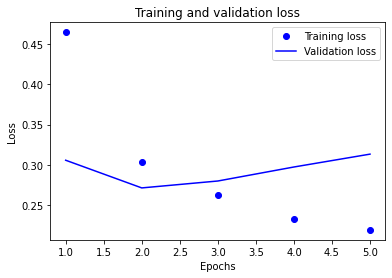

In [21]:
import matplotlib.pyplot as plt
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

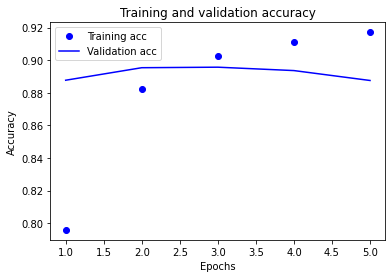

In [22]:
plt.clf()
acc = history_dict["accuracy"]
val_acc = history_dict["val_accuracy"]
plt.plot(epochs, acc, "bo", label="Training acc")
plt.plot(epochs, val_acc, "b", label="Validation acc")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## Sequence *model*
Ces modèles permettent de traiter une séquence de mots. On garde l'ordre

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization

#on prend des séquences de 600 mots 
max_length = 600
max_tokens = 20000
text_vectorization = TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### One hot model
**Définition d'un modèle one hot** Attention l'entrainement du modèle peut prendre beaucoup de temps, à cause de l'entrée, chaque mot, il y'en a 600 par texte) est représenté par un vecteur de 20000 entrées???.

Les modèles (type de couches) sont définis isi : https://keras.io/api/layers/recurrent_layers/

In [ ]:
# sequene model avec une entrée en one_hot

import tensorflow as tf
inputs = keras.Input(shape=(None,), dtype="int64")

# chaque mot (indice) est représenté en one_hot vecteur (un vecteur de dimension 20000)
embedded = tf.one_hot(inputs, depth=max_tokens)

# ajout d'ue couche birectionnelle de type LSTM
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)

# couche de sortie simple couche 1 sortie pur la classification
outputs = layers.Dense(1, activation="sigmoid")(x)


model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

**Eentrainement d modèle**

In [ ]:
allbacks = [
    keras.callbacks.ModelCheckpoint("one_hot_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("one_hot_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

## ca prend beaucoup de temps
## l'entrée du modèle est formée de vecteurs de 600*20000 pour chaque texte ??
## trop gros

### Représentation des mots par des embeddings
 la couche d'embbeding a au moins deux paramètres (voir la classe embedding) (https://keras.io/api/layers/core_layers/embedding/):

- layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)

- le nombre d'entrée  et  la dimension de l'embedding ici 256

Cette couche prend les représentations  (indices des mots) et transforme chaque mot en un vecteur de dimensions 256, 
au lieu d'avoir 600 * 20000 on aura là 600 * 256.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens, output_dim=256)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_lstm.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_lstm.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

**Padding et masking**
- l'utilisation d'une dimension max_length va conduire à la vectorisation (rajout des zeros (padding)) quand la phrase est courte et sa troncature quand elle et longue
- la couche embedding permet de générer des "mask" indiquant aux coucheq du RNN de ne pas traiter les zéros.

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(
    input_dim=max_tokens, output_dim=256, mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    keras.callbacks.ModelCheckpoint("embeddings_bidir_gru_with_masking.keras",
                                    save_best_only=True)
]
model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("embeddings_bidir_gru_with_masking.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

### Utlisation des embeddings pré-entrainés
**On utilisera Glove** on le charge depuis le site de Stanford

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

In [ ]:
## parser le fichier 
import numpy as np
path_to_glove_file = "glove.6B.100d.txt"

embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

Found 400000 word vectors.


In [ ]:
## préparer la matrice glove (Word embedding)
embedding_dim = 100
# on récupère le vocabulaire indexé par TextVectorization (voir cellules du dessus)
vocabulary = text_vectorization.get_vocabulary()
# faire un mapping des mots vers leurs index
word_index = dict(zip(vocabulary, range(len(vocabulary))))

# on prpare la matrice des embeddings
embedding_matrix = np.zeros((max_tokens, embedding_dim))

# Pour chaque mot de l'index, 
# on parcours embeddings_index, on récupère son vecteur et on le met dans la matrice

for word, i in word_index.items():
    if i < max_tokens:
        embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
## on utilise une couche emdedding constante, elle ne sera pas entrainable
#trainable=False

embedding_layer = layers.Embedding(
    max_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
    mask_zero=True,
)

**Définition du modèle**

In [ ]:
inputs = keras.Input(shape=(None,), dtype="int64")
embedded = embedding_layer(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])
model.summary()


callbacks = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="glove_embeddings_sequence_model.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
hisory=model.fit(int_train_ds, validation_data=int_val_ds, epochs=10, callbacks=callbacks)
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 100)         2000000   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               34048     
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,034,113
Trainable params: 34,113
Non-trainable params: 2,000,000
____________________________________________

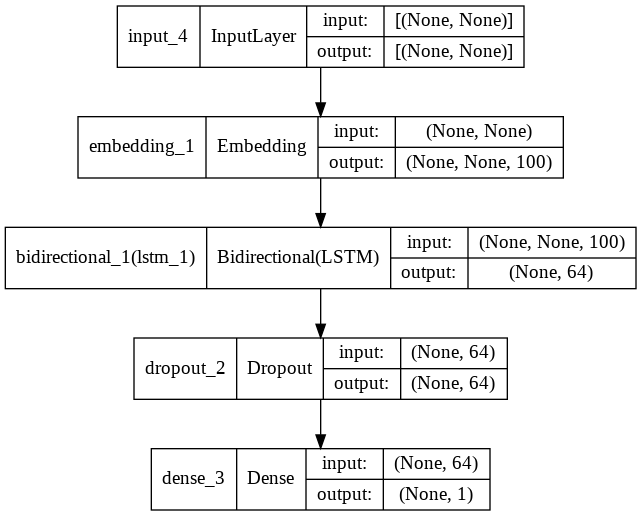

In [ ]:
dot_img_file = 'glove_embeddings_sequence_model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)

**Utilisation d'un modèle entrainé**

In [ ]:
# création d'un tensor

inputs = keras.Input(shape=(1,), dtype="string")
processed_inputs = text_vectorization(inputs)

# on peut appeler n'importe quel modèle que nous avons déjà sauvé
#model = keras.models.load_model("glove_embeddings_sequence_model.keras")

outputs = model(processed_inputs)
inference_model = keras.Model(inputs, outputs)

In [ ]:
import tensorflow as tf
raw_text_data = tf.convert_to_tensor([
    ["That was an excellent movie, I loved it."],
])
predictions = inference_model(raw_text_data)
print(f"{float(predictions[0] * 100):.2f} percent positive")

98.57 percent positive


In [ ]:
model = keras.models.load_model("glove_embeddings_sequence_model.keras")
history_dict = model.history
history_dict.keys()

In [ ]:
import matplotlib.pyplot as plt
history_dict = model.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Modèle à Convolution (CNN)

Ce type de modèle utilisé pour les images (le premier exemple porte sur une recherche d'image à partir du dataset cifar10). Le second exemple exploite un CNN sur notre texte.
2.1 Exemple classification d'images

####CNN Sur de l'image

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models, optimizers

import matplotlib.pyplot as plt

(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()
assert x_train.shape == (50000, 32, 32, 3)
assert x_test.shape == (10000, 32, 32, 3)
assert y_train.shape == (50000, 1)
assert y_test.shape == (10000, 1)


# input:   3 channels -> (32, 32, 3) tensors.
inputs = keras.Input(shape=(32, 32, 3))
# this applies 32 convolution filters of size 3x3 each.
x=layers.Conv2D(32, (3, 3), activation='relu')(inputs)
x=layers.MaxPooling2D(pool_size=(2, 2))(x)
x=layers.Conv2D(64, (3, 3), activation='relu')(x)
x=layers.MaxPooling2D(pool_size=(2, 2))(x)

x=layers.Flatten()(x)
x=layers.Dense(256, activation='relu')(x)
x=layers.Dropout(0.5)(x)
outputs=layers.Dense(10, activation='softmax')(x)
model = keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(1e-3))

#model.fit(x_train, y_train, batch_size=32, epochs=10)
model.summary()


#### CNN sur du Texte

In [5]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

hidden_dim=16
max_features=20000
embedding_dim=100

inputs = tf.keras.Input(shape=(max_features,), dtype="int64")
# A integer input for vocab indices.
inputs = tf.keras.Input(shape=(None,), dtype="int64")

# Next, we add a layer to map those vocab indices into a space of dimensionality
# 'embedding_dim'.
x = layers.Embedding(max_features, embedding_dim)(inputs)
x = layers.Dropout(0.5)(x)

# Conv1D + global max pooling
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(x)
x = layers.GlobalMaxPooling1D()(x)

# We add a vanilla hidden layer:
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# We project onto a single unit output layer, and squash it with a sigmoid:
outputs = layers.Dense(1, activation="sigmoid", name="predictions")(x)

model_cnn = tf.keras.Model(inputs, outputs)

# Compile the model with binary crossentropy loss and an adam optimizer.
model_cnn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

